#Table Of Contents

* <a href='#0'>0. About Amazon Fine Food Reviews Analysis</a>  


- <a href='#1'>1. Reading Data</a>  
  - <a href='#11'>1.1. Loading Necessary Libraries </a>
  - <a href='#12'>1.2. Loading the data </a>


- <a href='#2'>2. Exploratory Data Analysis </a>
  - <a href='#21'>2.1 Data Cleaning: Deduplication</a>


- <a href='#3'>  3. Preprocessing </a>
  - <a href='#31'>  3.1. Preprocessing Review Text </a>

- <a href='#4'>  4. Splitting preprocessed reviews into train, cross validate and test datasets </a>


- <a href='#5'>  5. Featurization </a>
  - <a href='#51'> 5.1 Featurizing data using Bag Of Words(BoW) </a>
  - <a href='#51'>5.2 Featurizing data using TFIDF </a>


- <a href='#6'>  6. Building Machine Learning Models </a>
  - <a href='#61'>6.1. Building Random Forest Model </a>
    - <a href='#611'>6.1.1. Applying Random Forests on BoW</a>
     - <a href='#6111'> 6.1.1.1 Plotting heatmaps to understand AUC score for optimal no. of estimators and max depth better </a>
     - <a href='#6112'> 6.1.1.2. Evaluation metrics </a>
     - <a href='#6113'> 6.1.1.3. Feature Importance </a>
    - <a href='#611'>6.1.2. Applying Random Forests on TFIDF </a>
      - <a href='#6121'>6.1.2.1 Plotting heatmaps to understand AUC score for optimal no. of estimators and max depth better </a>
      - <a href='#6122'>6.1.2.2. Evaluation metrics </a>
      - <a href='#6123'>6.1.2.3. Feature Importance </a>
  - <a href='#62'>6.2 Building GBDT Model using XGBOOST </a>
    - <a href='#621'>6.2.1. Applying XGBOOST on BOW </a>
      - <a href='#6211'>6.2.1.1. Evaluation metrics </a>
    - <a href='#622'>6.2.2. Applying XGBOOST on TFIDF </a>
      - <a href='#6211'>6.2.2.1. Evaluation metrics </a>

- <a href='#7'> 7. Model Performance Summary </a>


- <a href='#8'> 8. Observations </a>

# <a id='0'>0. About Amazon Fine Food Reviews Analysis</a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

<img src="https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2016/04/AmazonReview-300x189.png" width="600">


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# <a id='1'>1. Reading Data</a>

### <a id='11'>1.1. Loading Necessary Libraries </a>

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

###<a id='12'> 1.2. Loading the data </a>

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

# <a id='2'>2. Exploratory Data Analysis </a>

### <a id='21'>2.1 Data Cleaning: Deduplication </a>

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# <a id='3'>3. Preprocessing </a>

### <a id='31'> 3.1. Preprocessing Review Text </a>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:31<00:00, 2760.02it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# <a id='4'>4. Splitting preprocessed reviews into train, cross validate and test datasets </a>

<font color='red'>Note: Splitting data into train, test, and cross validate datasets before vectorizing the data because of Data Leakage problem.
</font>

> **Data leakage:** 
- It is a condition when the test data is already seen by the model during the training phase.
- In a way, the model sees the test data prior to testing stage.
- Hence, it results in biased results. 
- Generally happens because of unknowingly using the entire data for training purpose.

In [26]:
from sklearn.model_selection  import train_test_split

X=preprocessed_reviews
y=np.array(final['Score'])

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)


# <a id='5'>5. Featurization </a>

### <a id='51'> 5.1 Featurizing data using Bag Of Words(BoW) </a>

In [28]:
count_vect = CountVectorizer()
X_train_bow=count_vect.fit_transform(X_train)
X_cv_bow=count_vect.transform(X_cv)
X_test_bow=count_vect.transform(X_test)

#Standardizing data
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow= scalar.transform(X_test_bow)
X_cv_bow=scalar.transform(X_cv_bow)

## <a id='52'> 5.2 Featurizing data using TFIDF </a>

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf=tf_idf_vect.fit_transform(X_train)
X_cv_tf=tf_idf_vect.transform(X_cv)
X_test_tf=tf_idf_vect.transform(X_test)

#Standardizing data
scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf= scalar.transform(X_test_tf)
X_cv_tf=scalar.transform(X_cv_tf)

# <a id='6'> 6. Building Machine Learning Models </a>

### <a id='61'> 6.1. Building Random Forest Model </a>

In [37]:
#Loading necessary libraries

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### <a id='611'> 6.1.1. Applying Random Forests on BoW </a>

In [32]:
#Hyperparameter tuning

base_learners = [60,80,100,120]
depths=[500,900,1200]
param_grid={'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features='sqrt')
model=GridSearchCV(rf,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model.fit(X_train_bow,y_train)

optimal_n_estimators = model.best_estimator_.n_estimators
optimal_max_depth = model.best_estimator_.max_depth
print("optimal n_estimators",optimal_n_estimators)
print("optimal max_depth",optimal_max_depth)


optimal n_estimators 120
optimal max_depth 500


### <a id='612'> 6.1.1.1 Plotting heatmaps to understand AUC score for optimal no. of estimators and max depth better </a>

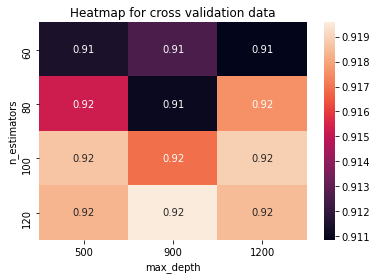

In [33]:
import seaborn as sns
X=[]
Y=[]
Z=[]
Zt=[]
for bl in base_learners:
    for d in depths:
        rf=RandomForestClassifier(max_features='sqrt',max_depth=d,n_estimators=bl)
        rf.fit(X_train_bow,y_train)
        pred=rf.predict_proba(X_cv_bow)[:,1]
        predt=rf.predict_proba(X_train_bow)[:,1]
        X.append(bl)
        Y.append(d)
        Z.append(roc_auc_score(y_cv,pred))
        Zt.append(roc_auc_score(y_train,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

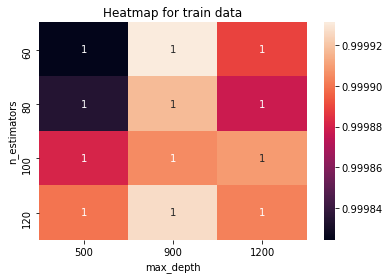

In [34]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Zt})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

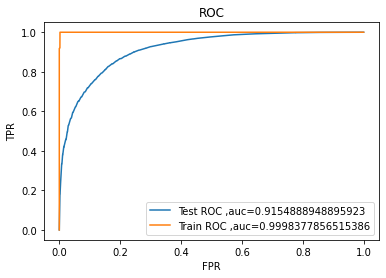

In [35]:
#Plotting ROC curve

rf=RandomForestClassifier(max_features='sqrt',max_depth=optimal_max_depth,n_estimators=optimal_n_estimators)
rf.fit(X_train_bow,y_train)
predi=rf.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=rf.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### <a id='6112'> 6.1.1.2. Evaluation metrics </a>

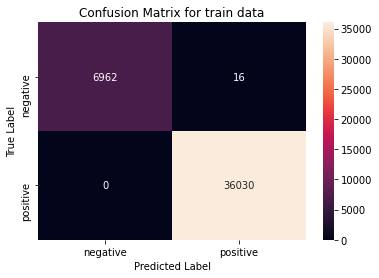



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6978
           1       1.00      1.00      1.00     36030

    accuracy                           1.00     43008
   macro avg       1.00      1.00      1.00     43008
weighted avg       1.00      1.00      1.00     43008



In [38]:
#Confusion matrix using heatmap for train data

predic=rf.predict(X_train_bow)

conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_train,predic))

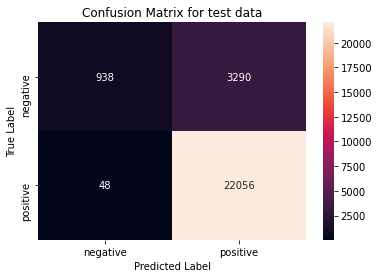



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.95      0.22      0.36      4228
           1       0.87      1.00      0.93     22104

    accuracy                           0.87     26332
   macro avg       0.91      0.61      0.64     26332
weighted avg       0.88      0.87      0.84     26332



In [39]:
#Confusion matrix using heatmap for test data

predic=rf.predict(X_test_bow)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))

### <a id='6113'> 6.1.1.3. Feature Importance </a>

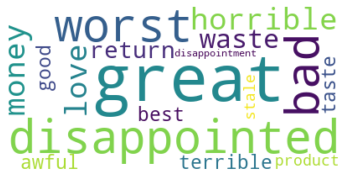

In [40]:
#Top 20 important features
all_features = count_vect.get_feature_names()
data=''
feat=rf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=all_features[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## <a id='612'> 6.1.2. Applying Random Forests on TFIDF </a>

In [42]:
base_learners = [60,80,100,120]
depths=[500,900,1200]
param_grid={'n_estimators': base_learners, 'max_depth':depths}

rf = RandomForestClassifier(max_features='sqrt')
model=GridSearchCV(rf,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model.fit(X_train_tf,y_train)

optimal_n_estimators = model.best_estimator_.n_estimators
optimal_max_depth = model.best_estimator_.max_depth
print("optimal n_estimators",optimal_n_estimators)
print("optimal max_depth",optimal_max_depth)

optimal n_estimators 120
optimal max_depth 900


### <a id='6121'> 6.1.2.1 Plotting heatmaps to understand AUC score for optimal no. of estimators and max depth better </a>

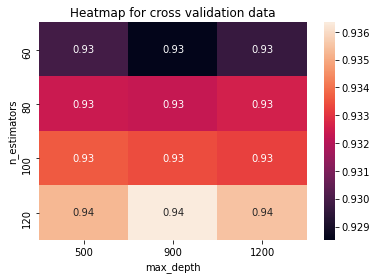

In [43]:

X=[]
Y=[]
Z=[]
Zt=[]
for bl in base_learners:
    for d in depths:
        rf=RandomForestClassifier(max_features='sqrt',max_depth=d,n_estimators=bl)
        rf.fit(X_train_tf,y_train)
        pred=rf.predict_proba(X_cv_tf)[:,1]
        predt=rf.predict_proba(X_train_tf)[:,1]
        X.append(bl)
        Y.append(d)
        Z.append(roc_auc_score(y_cv,pred))
        Zt.append(roc_auc_score(y_train,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()



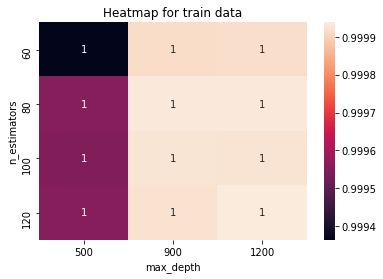

In [44]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Zt})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

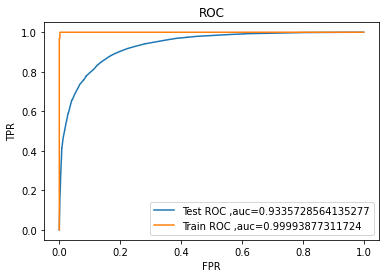

In [45]:
#Plotting ROC curve

rf=RandomForestClassifier(max_features='sqrt',max_depth=optimal_max_depth,n_estimators=optimal_n_estimators)
rf.fit(X_train_tf,y_train)
predi=rf.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=rf.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### <a id='6122'>6.1.2.2. Evaluation metrics </a>

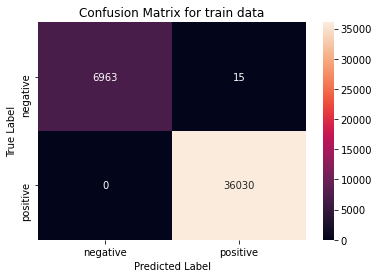



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6978
           1       1.00      1.00      1.00     36030

    accuracy                           1.00     43008
   macro avg       1.00      1.00      1.00     43008
weighted avg       1.00      1.00      1.00     43008



In [47]:
#Confusion matrix using heatmap for train data

predic=rf.predict(X_train_tf)

conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_train,predic))

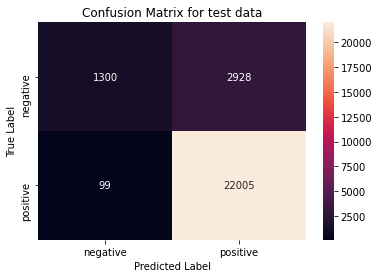



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.93      0.31      0.46      4228
           1       0.88      1.00      0.94     22104

    accuracy                           0.89     26332
   macro avg       0.91      0.65      0.70     26332
weighted avg       0.89      0.89      0.86     26332



In [48]:
#Confusion matrix using heatmap for test data

predic=rf.predict(X_test_tf)

conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))

### <a id='6123'>6.1.2.3. Feature Importance </a>

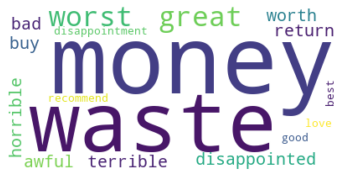

In [49]:
# Top 20 features
all_features = tf_idf_vect.get_feature_names()
data=''
feat=rf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=all_features[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### <a id='62'> 6.2 Building GBDT Model  using XGBOOST </a>

### <a id='621'> 6.2.1. Applying XGBOOST on BOW </a>

optimal depth :  500
optimal n_estimator :  120


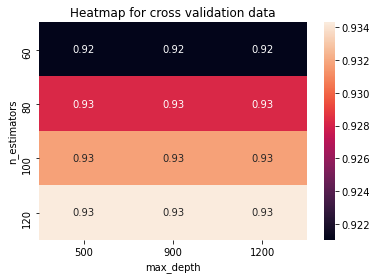

In [50]:
from xgboost import XGBClassifier

base_learners = [60,80,100,120]
depths=[500,900,1200]

import seaborn as sns
X=[]
Y=[]
Z=[]
Zt=[]
for bl in base_learners:
    for d in depths:
        gbdt=XGBClassifier(booster='gbtree' ,max_depth=d,n_estimators=bl)        
        gbdt.fit(X_train_bow,y_train)
        pred=gbdt.predict_proba(X_cv_bow)[:,1]
        predt=gbdt.predict_proba(X_train_bow)[:,1]
        X.append(bl)
        Y.append(d)
        Z.append(roc_auc_score(y_cv,pred))
        Zt.append(roc_auc_score(y_train,predt))

optimal_depth=Y[Z.index(max(Z))]   
optimal_n_estimator=X[Z.index(max(Z))]

print('optimal depth : ',optimal_depth)
print('optimal n_estimator : ',optimal_n_estimator)
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()



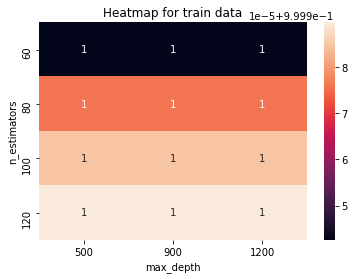

In [51]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Zt})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

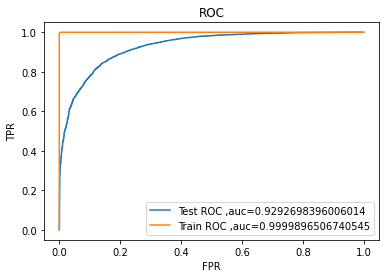

In [52]:
#Plotting ROC curve

gbdt=XGBClassifier(booster='gbtree' ,max_depth=optimal_depth,n_estimators=optimal_n_estimator)
gbdt.fit(X_train_bow,y_train)
predi=gbdt.predict_proba(X_test_bow)[:,1]

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=gbdt.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### <a id='6211'> 6.2.1.1. Evaluation metrics </a>

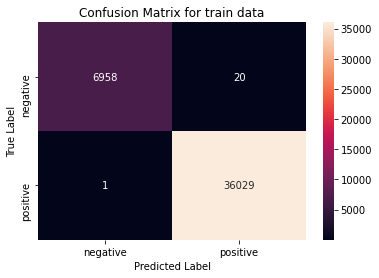



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6978
           1       1.00      1.00      1.00     36030

    accuracy                           1.00     43008
   macro avg       1.00      1.00      1.00     43008
weighted avg       1.00      1.00      1.00     43008



In [53]:
#Confusion matrix using heatmap for train data

predic=gbdt.predict(X_train_bow)

conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_train,predic))

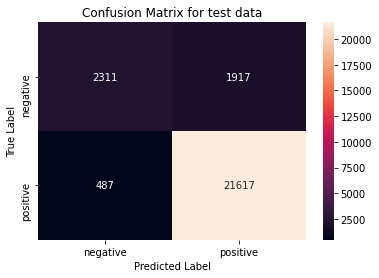



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.83      0.55      0.66      4228
           1       0.92      0.98      0.95     22104

    accuracy                           0.91     26332
   macro avg       0.87      0.76      0.80     26332
weighted avg       0.90      0.91      0.90     26332



In [54]:
#Confusion matrix using heatmap for test data

predic=gbdt.predict(X_test_bow)

conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))

### <a id='622'> 6.2.2. Applying XGBOOST on TFIDF </a>

optimal depth :  500
optimal n_estimator :  120


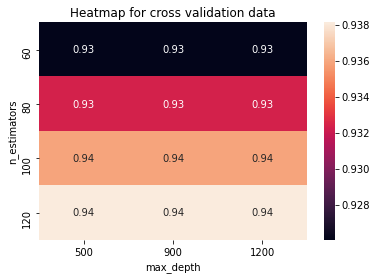

In [55]:
base_learners = [60,80,100,120]
depths=[500,900,1200]

X=[]
Y=[]
Z=[]
Zt=[]
for bl in base_learners:
    for d in depths:
        gbdt=XGBClassifier(booster='gbtree' ,max_depth=d,n_estimators=bl)        
        gbdt.fit(X_train_tf,y_train)
        pred=gbdt.predict_proba(X_cv_tf)[:,1]
        predt=gbdt.predict_proba(X_train_tf)[:,1]
        X.append(bl)
        Y.append(d)
        Z.append(roc_auc_score(y_cv,pred))
        Zt.append(roc_auc_score(y_train,predt))

optimal_depth=Y[Z.index(max(Z))]   
optimal_n_estimator=X[Z.index(max(Z))]

print('optimal depth : ',optimal_depth)
print('optimal n_estimator : ',optimal_n_estimator)
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

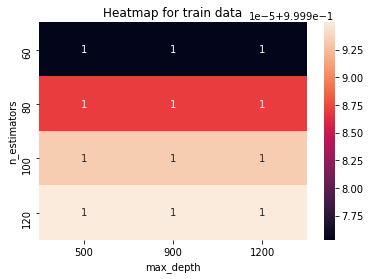

In [56]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Zt})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

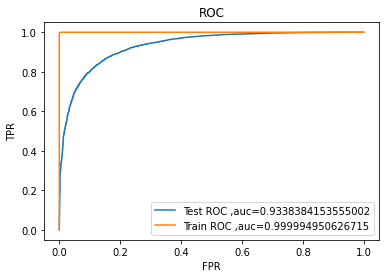

In [57]:
#Plotting ROC 

gbdt=XGBClassifier(booster='gbtree' ,max_depth=optimal_depth,n_estimators=optimal_n_estimator)
gbdt.fit(X_train_tf,y_train)
predi=gbdt.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=gbdt.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### <a id='6221'> 6.2.2.1. Evaluation metrics </a>

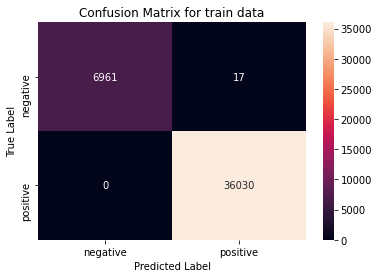



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6978
           1       1.00      1.00      1.00     36030

    accuracy                           1.00     43008
   macro avg       1.00      1.00      1.00     43008
weighted avg       1.00      1.00      1.00     43008



In [58]:
#Confusion matrix using heatmap for train data

predic=gbdt.predict(X_train_tf)

conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_train,predic))

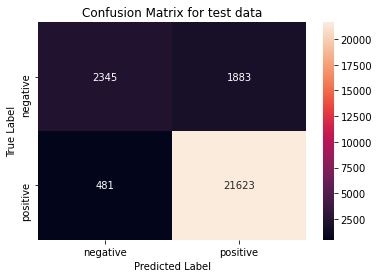



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.83      0.55      0.66      4228
           1       0.92      0.98      0.95     22104

    accuracy                           0.91     26332
   macro avg       0.87      0.77      0.81     26332
weighted avg       0.91      0.91      0.90     26332



In [59]:
#Confusion matrix using heatmap for test data

predic=gbdt.predict(X_test_tf)

conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))

# <a id='7'> 7. Model Performance Summary</a>

In [1]:
from prettytable import PrettyTable    

x = PrettyTable()
x.field_names = ["Model","Vectorizer","optimal max_depth", "optimal n_estimators", "AUC"]
x.add_row(['Random Forest','BOW','500','120','0.915'])
x.add_row(['Random Forest','TFIDF','900','120','0.933'])

x.add_row(['XGBOOST GBDT','Bow','500','120','0.929'])
x.add_row(['XGBOOST GBDT','TFIDF','500','120','0.933'])

print(x)

+---------------+------------+-------------------+----------------------+-------+
|     Model     | Vectorizer | optimal max_depth | optimal n_estimators |  AUC  |
+---------------+------------+-------------------+----------------------+-------+
| Random Forest |    BOW     |        500        |         120          | 0.915 |
| Random Forest |   TFIDF    |        900        |         120          | 0.933 |
|  XGBOOST GBDT |    Bow     |        500        |         120          | 0.929 |
|  XGBOOST GBDT |   TFIDF    |        500        |         120          | 0.933 |
+---------------+------------+-------------------+----------------------+-------+


# <a id='8'> 8. Observations</a>
0) First we splitted whole data into train, cross-validate, and test datasets

1) Then, we featurized the text data(reviews) into numerical vectors using Bag of Words(BoW) and TF-IDF, text featurization techniques.

2) We built Random forest and XGBoost models to find out whether a given review is positive or negative.

2) For this we took 100k datapoints out of the total ~ 568k datapoints, because of hardware constraints.

3) In each model we figured out our best hyperparamter max_depth and n_estimator and plotted heatmap for both train and cv data, after hyperparameter tuning we plotted the ROC curve for both train as well as test data.

4) At the end we displayed best hyperparamters and AUC value of both the models using prettytable.